# Required versions to install
```
import cv2
import numpy
print("NumPy:", numpy.__version__)
print("OpenCV:", cv2.__version__)
!python --version
```

- Python 3.10.13
- NumPy: 1.26.4
- OpenCV: 4.9.0

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import pickle

import torch.nn as nn
import torch
import torch.nn.functional as F

from torchvision.transforms import v2
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm
import gc
from IPython.display import clear_output

from skimage.measure import moments_central, moments_hu, moments_normalized
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from skimage.util import view_as_windows

C:\Users\fix_e\AppData\Local\Temp\ipykernel_15544\362677734.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
input_path = './data/'

output_path = './output/'


In [3]:
train_photo_paths = [input_path + 'train/image/' + x for x in os.listdir(input_path + 'train/image/')]
train_label_paths = [input_path + 'train/mask/' + x for x in os.listdir(input_path + 'train/mask/')]

In [4]:
train_raw_photos = [cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)  for path in train_photo_paths]
train_masks = [cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2GRAY) for path in train_label_paths]
train_masks = [np.where(mask > 0, 255, 0) for mask in train_masks]

In [5]:
#imagesSet structure is [row1, row2,..., rown] where rowi is [image1, image2,..., imagen]
def plot_images(imagesSet, title, figsize=(20, 10), cmap=None):
    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=20)
    for i in range(len(imagesSet[0])):
        for j in range(len(imagesSet)):
            plt.subplot(len(imagesSet), len(imagesSet[0]), i + j*len(imagesSet[0]) + 1)
            plt.imshow(imagesSet[j][i], cmap=cmap)
            plt.axis('off')
        plt.tight_layout()

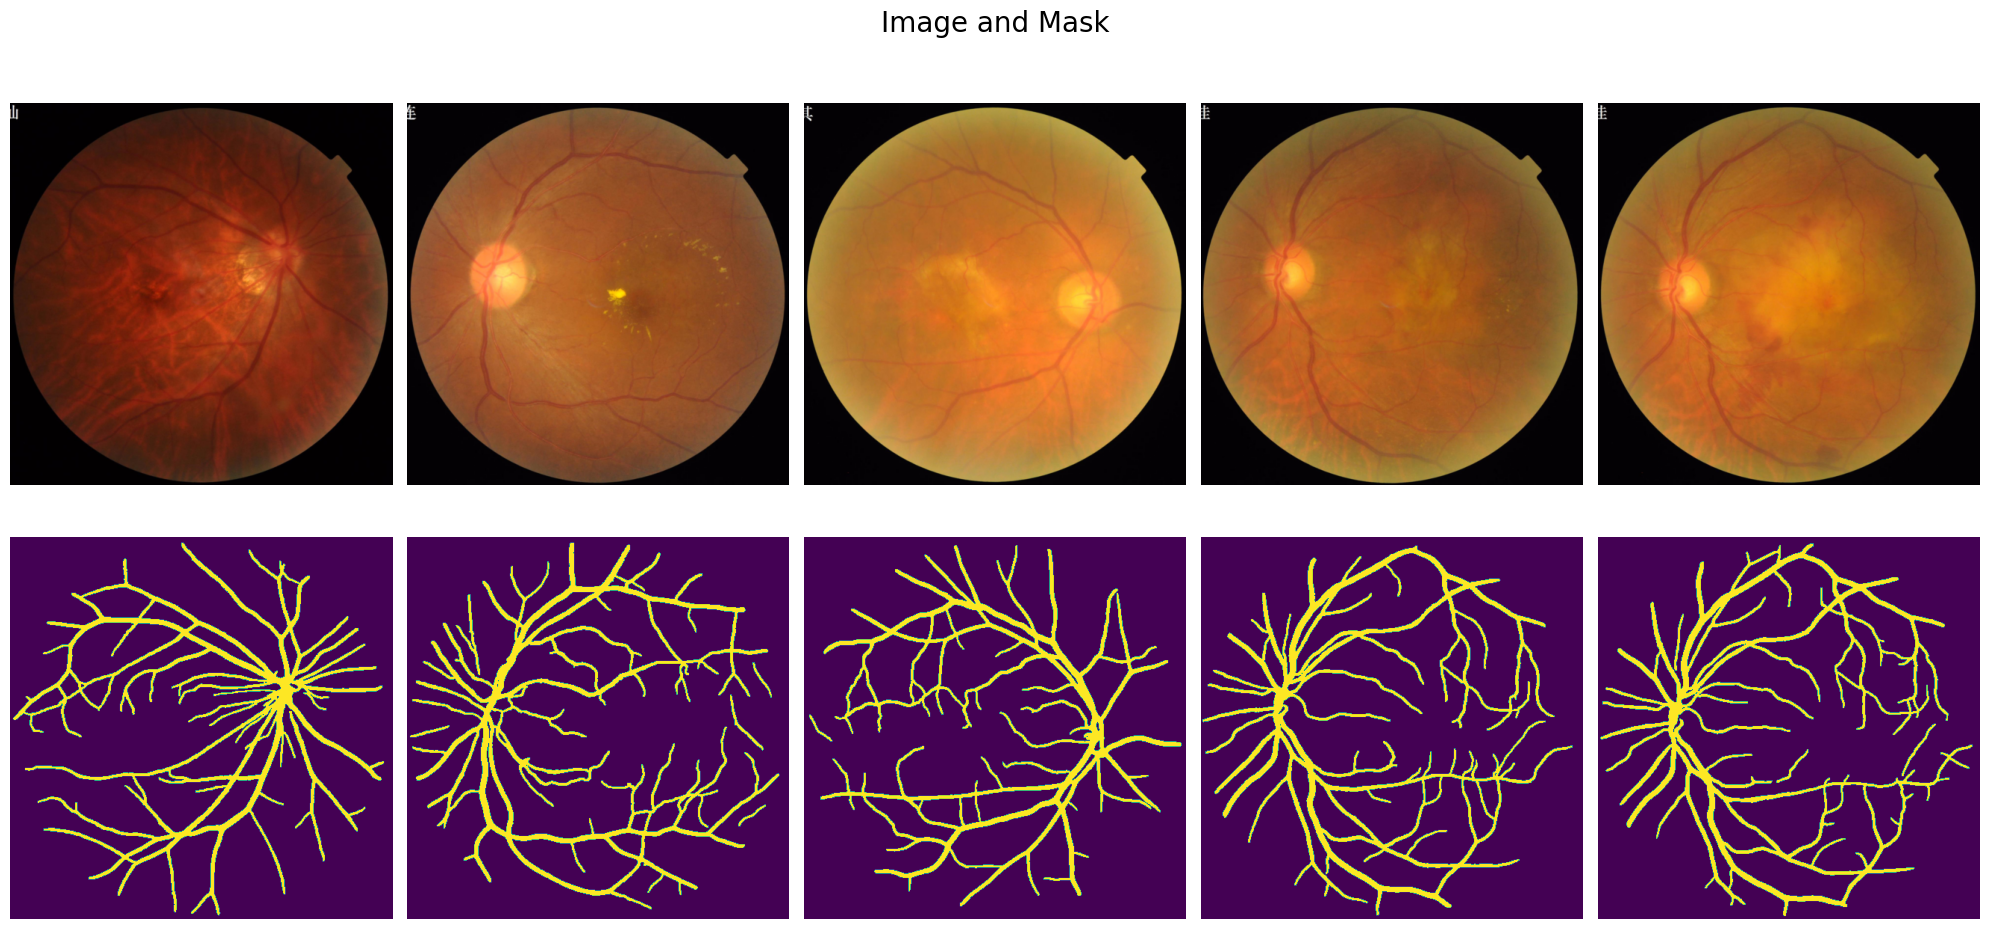

In [6]:
plot_images([train_raw_photos[:5], train_masks[:5]], 'Image and Mask')

# Prepocessing

### 1. Color Channels

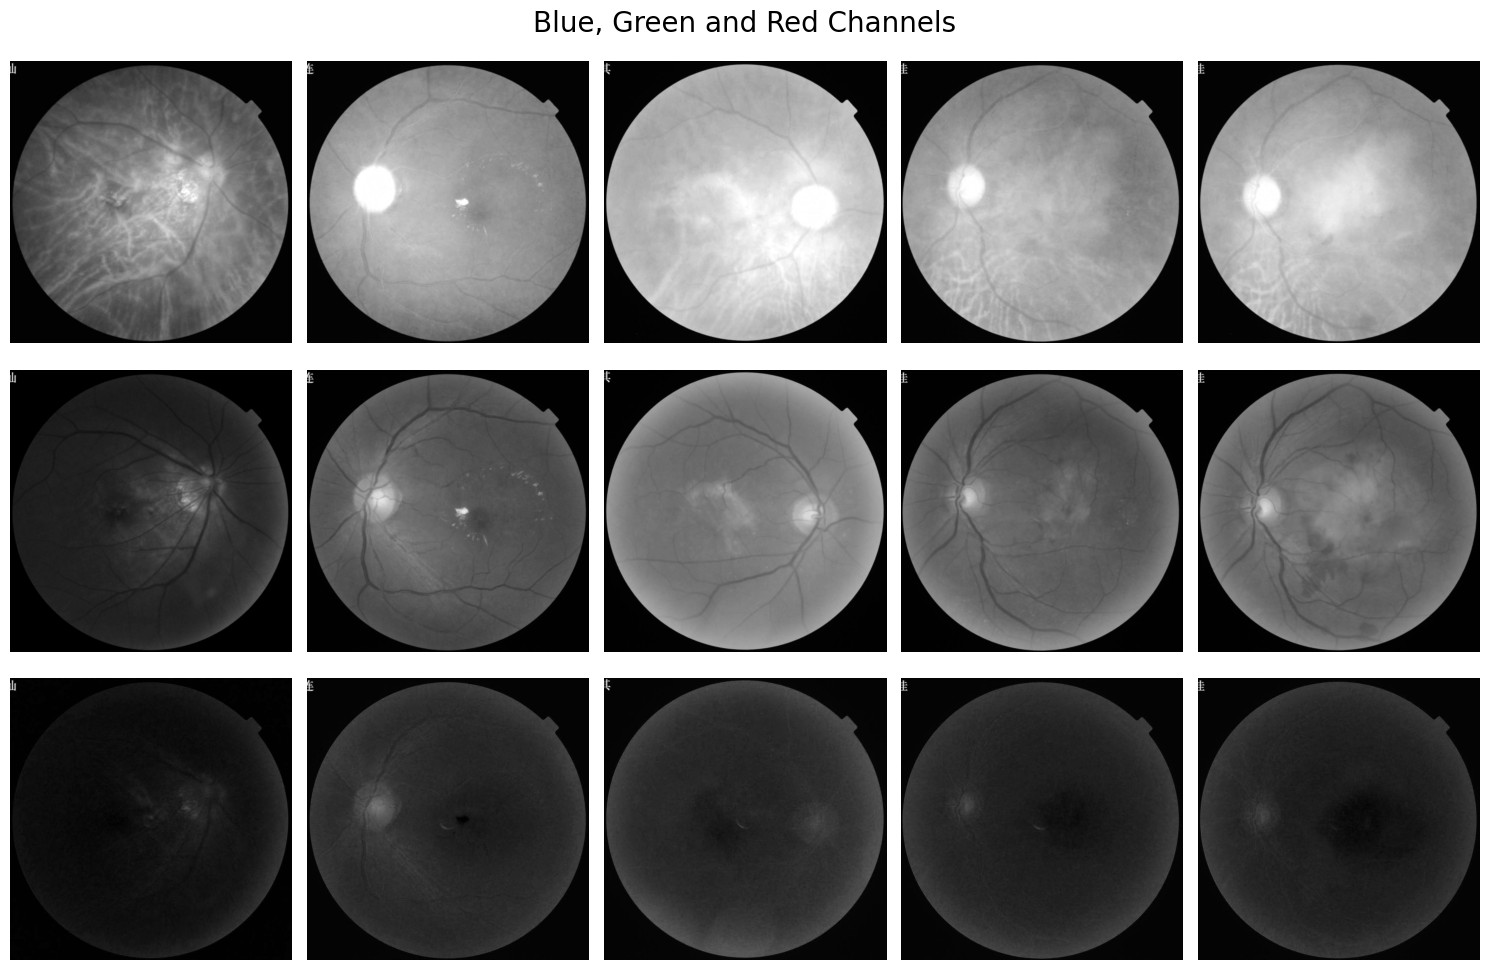

In [7]:
train_photos_blue = [photo[:, :, 0] for photo in train_raw_photos]
train_photos_green = [photo[:, :, 1] for photo in train_raw_photos]
train_photos_red = [photo[:, :, 2] for photo in train_raw_photos]

plot_images([train_photos_blue[:5], train_photos_green[:5], train_photos_red[:5]], 'Blue, Green and Red Channels', figsize=(15,10), cmap='gray')

### 2. Contrast Enhancement

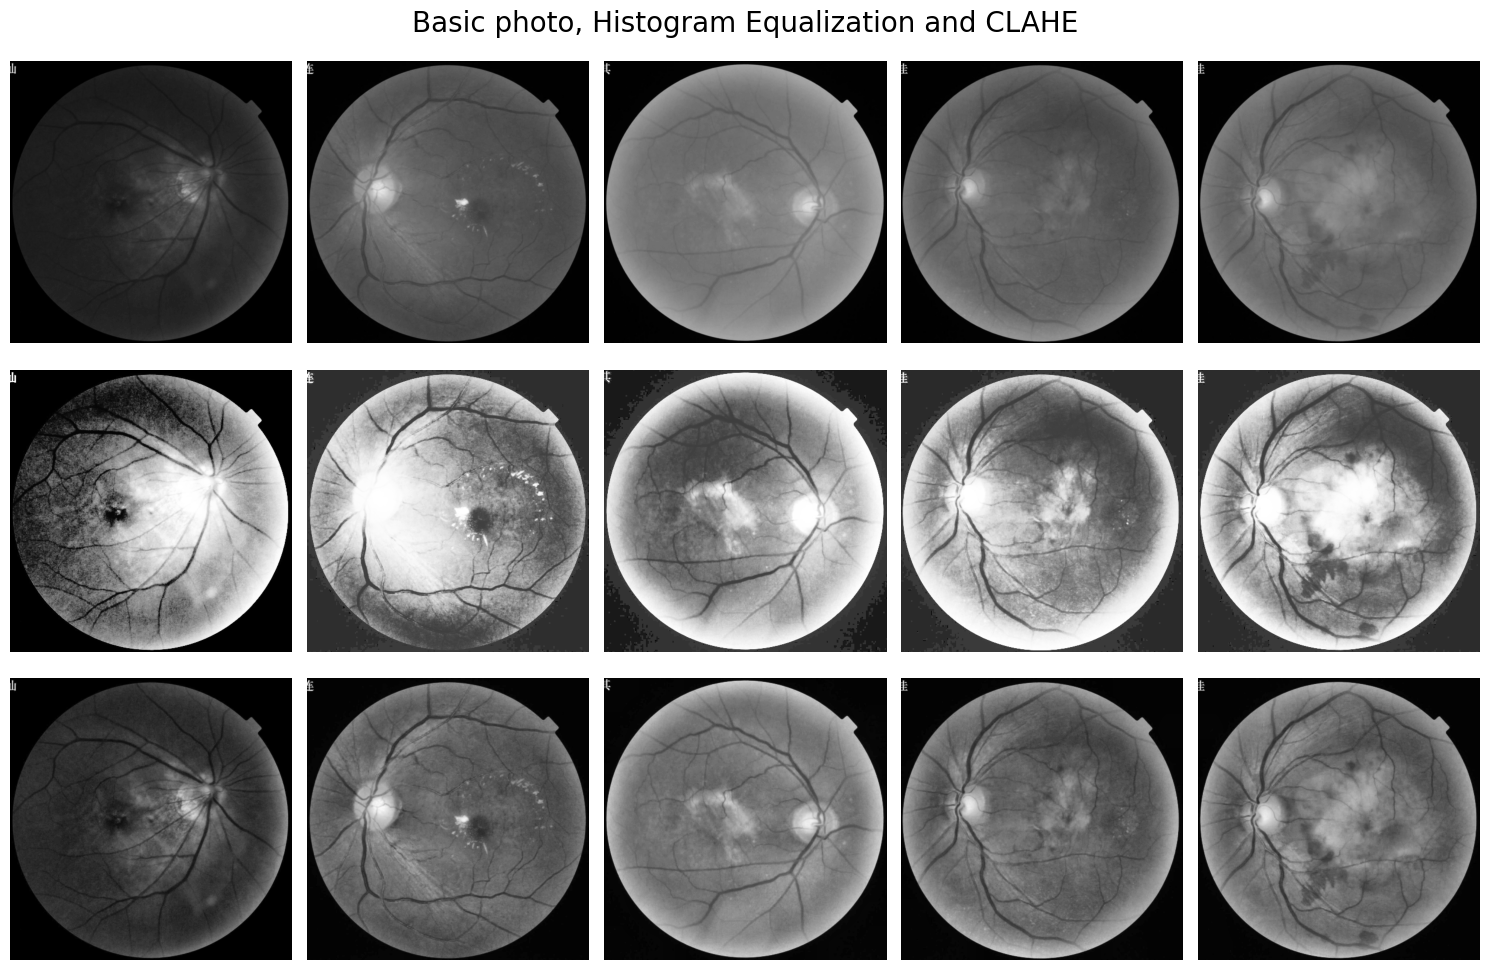

In [8]:
#HE
train_photos_eq_sample = [cv2.equalizeHist(photo) for photo in train_photos_green[:5]]

#CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
train_photos_clahe_sample = [clahe.apply(photo) for photo in train_photos_green[:5]]

plot_images([train_photos_green[:5], train_photos_eq_sample, train_photos_clahe_sample], 'Basic photo, Histogram Equalization and CLAHE', figsize=(15,10), cmap='gray')

In [9]:
train_photos_clahe =  [clahe.apply(photo) for photo in train_photos_green]

In [10]:
train_photos = train_photos_clahe

# Simple vessel extracting - gradient enhancement

### Sharr vs sobel operator

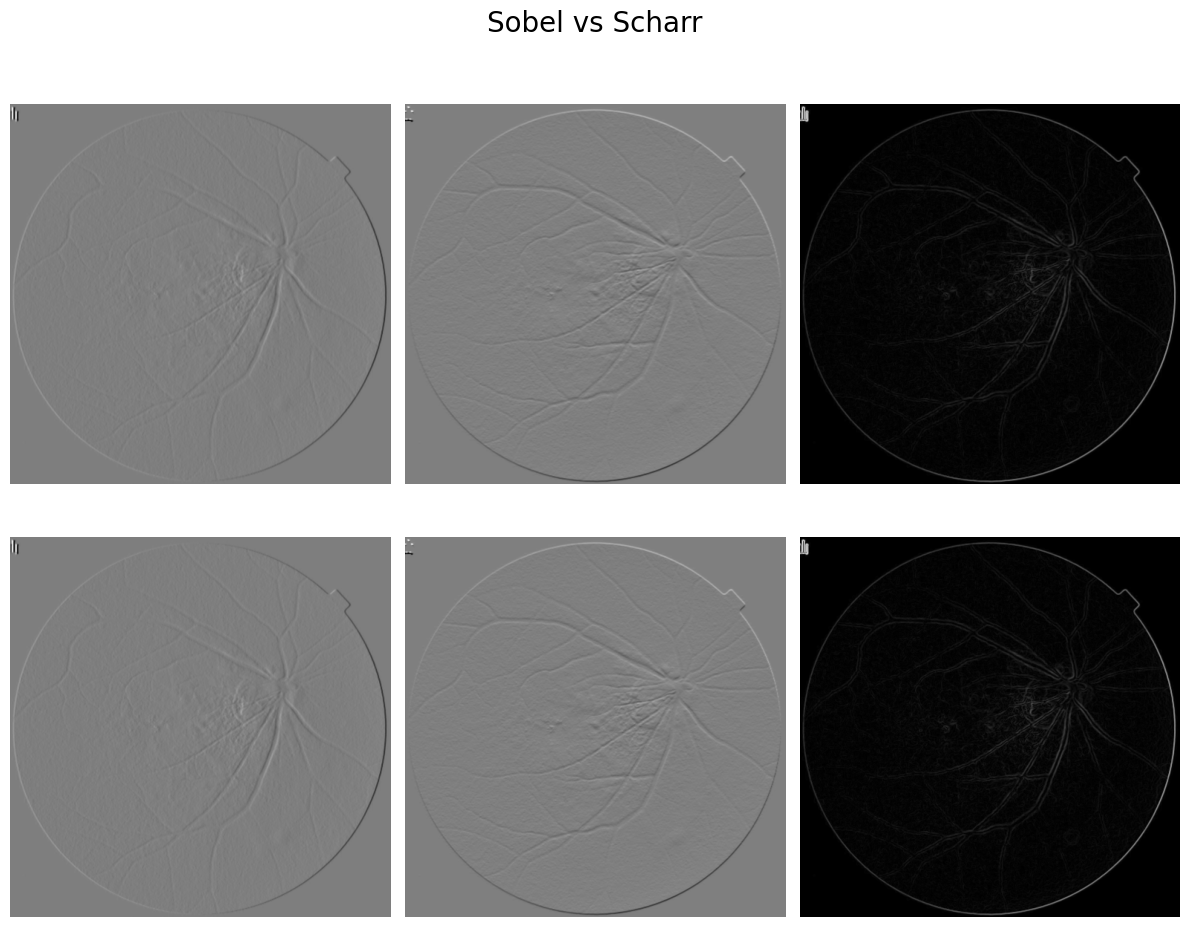

In [11]:
#sobel operator
sobel_x = cv2.Sobel(train_photos[0], cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(train_photos[0], cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobel_x, sobel_y)

scharr_x = cv2.Scharr(train_photos[0], cv2.CV_64F, 1, 0)
scharr_y = cv2.Scharr(train_photos[0], cv2.CV_64F, 0, 1)
scharr = cv2.magnitude(scharr_x, scharr_y)

plot_images([[sobel_x, sobel_y, sobel], [scharr_x, scharr_y, scharr]], 'Sobel vs Scharr', figsize=(12, 10), cmap='gray')

In [12]:
#apply sharr operator to all images
train_photos_scharr_x = [cv2.Scharr(photo, cv2.CV_64F, 1, 0) for photo in train_photos]
train_photos_scharr_y = [cv2.Scharr(photo, cv2.CV_64F, 0, 1) for photo in train_photos]
sharr_results = [cv2.magnitude(scharr_x, scharr_y) for scharr_x, scharr_y in zip(train_photos_scharr_x, train_photos_scharr_y)]

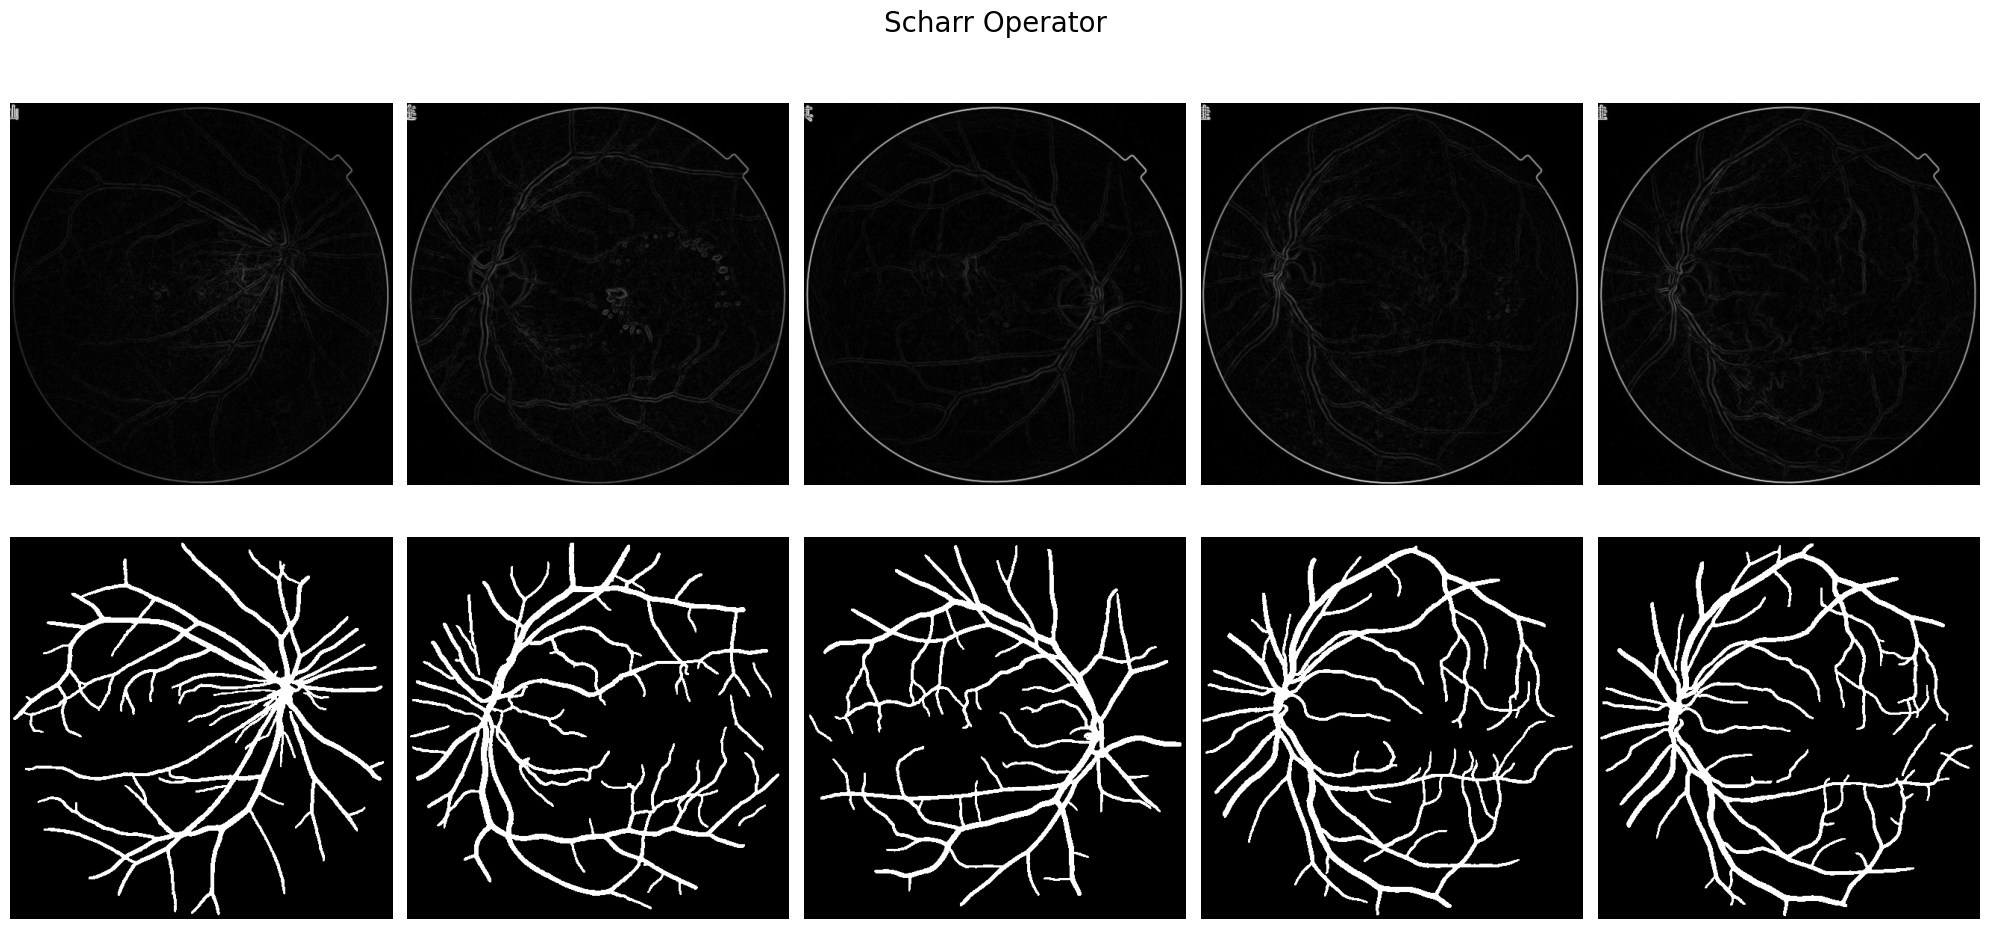

In [13]:
plot_images([sharr_results[:5], train_masks[:5]], 'Scharr Operator', figsize=(20, 10), cmap='gray')

### Postprocessing

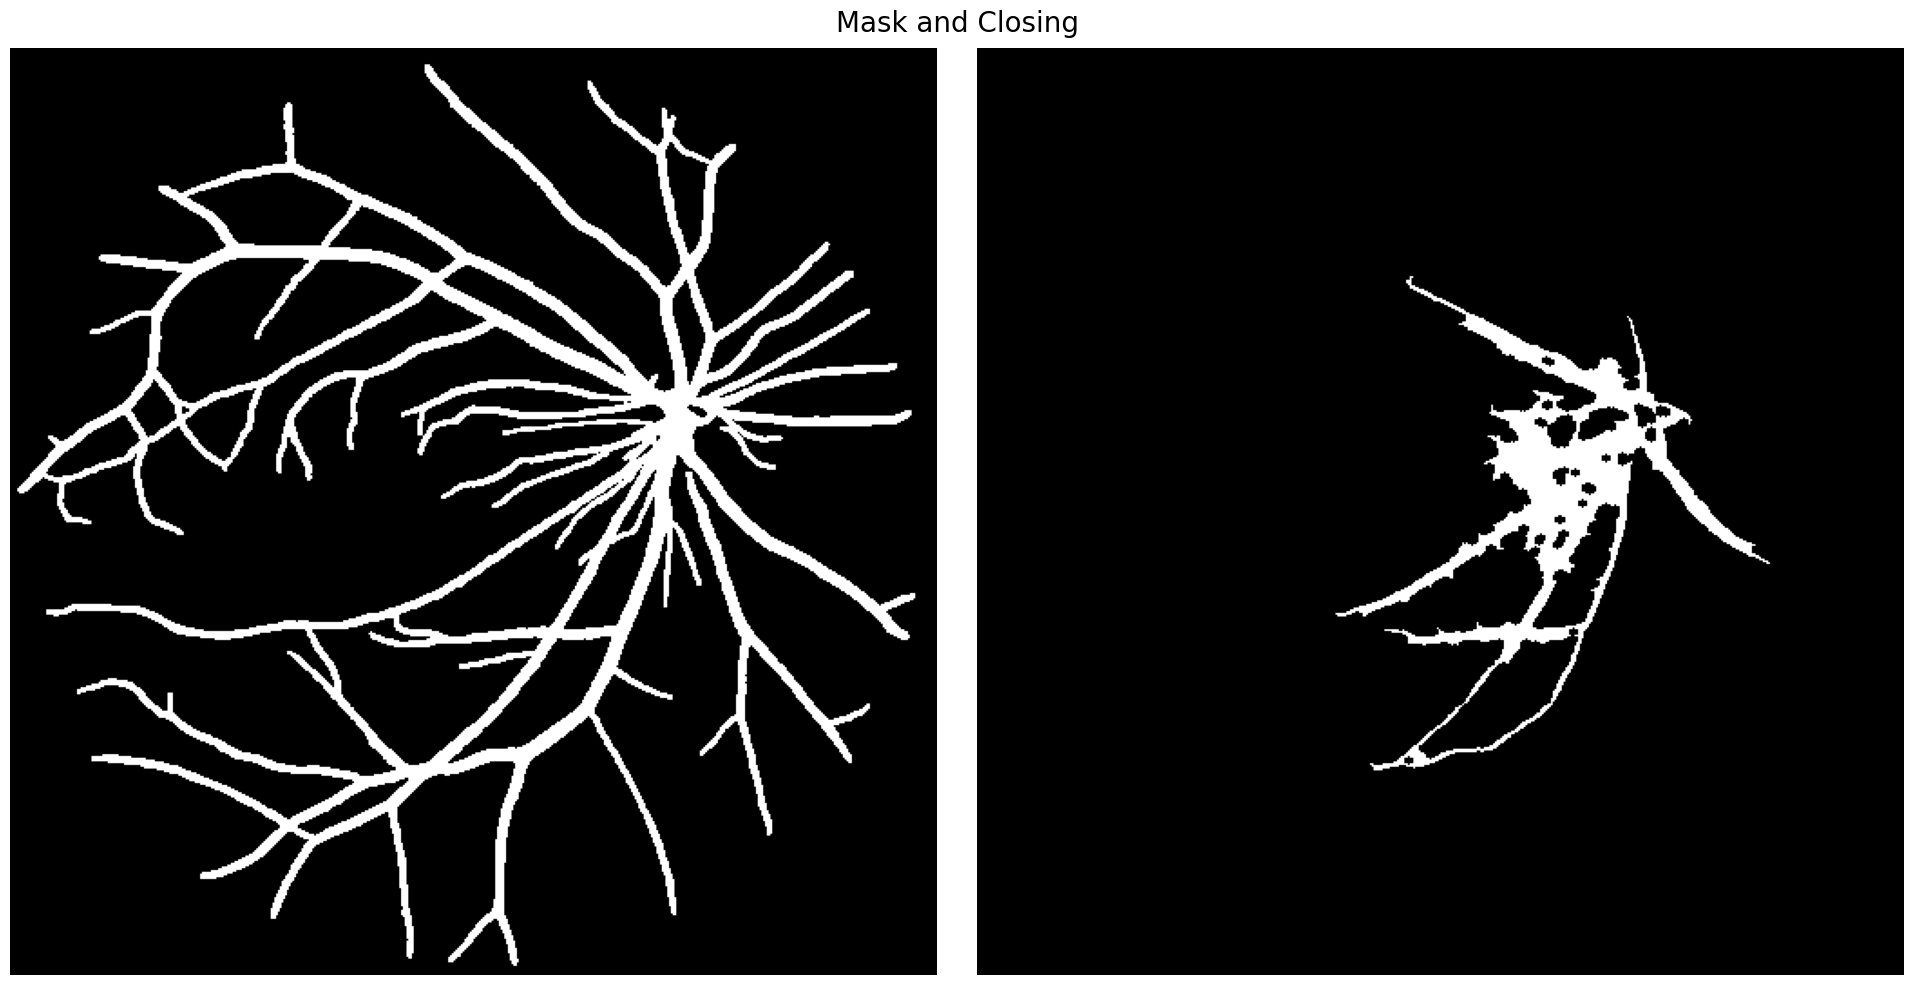

In [14]:
def basic_approach_postprocess(masks):
    postprocessed_masks = [cv2.threshold(mask, 255, 255, cv2.THRESH_BINARY)[1] for mask in masks]

    postprocessed_masks = np.array(postprocessed_masks).astype(np.uint8)

    # makeing black everything that is not connected to the biggest white object
    for i in range(len(postprocessed_masks)):
        nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(postprocessed_masks[i])
        max_label = 0
        max_size = 0
        for j in range(1, nlabels):
            if stats[j, cv2.CC_STAT_AREA] > max_size:
                max_label = j
                max_size = stats[j, cv2.CC_STAT_AREA]
        postprocessed_masks[i][labels != max_label] = 0

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    postprocessed_masks = [cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) for mask in postprocessed_masks]

    return postprocessed_masks

postprocessed_masks = basic_approach_postprocess(sharr_results)

plot_images([[train_masks[0], postprocessed_masks[0]]], 'Mask and Closing', cmap='gray')

# Quality of the results
# (It will run with Mask Images)

Test dataset

In [15]:
test_photo_paths = [input_path + 'test/image/' + x for x in os.listdir(input_path + 'test/image/')]
test_label_paths = [input_path + 'test/mask/' + x for x in os.listdir(input_path + 'test/mask/')]

# Updated Code to check the exact curropt file
# --------------------------------------------
test_raw_photos = []
for path in test_photo_paths:
    img = cv2.imread(str(path))
    if img is not None:
        test_raw_photos.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        print(f"Warning: Unable to read {path}")
# --------------------------------------------

test_raw_photos = [cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB) for path in test_photo_paths]
test_masks = [cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2GRAY) for path in test_label_paths]
test_masks = np.array(test_masks).astype(np.uint8)
test_masks = [np.where(mask > 0, 255, 0) for mask in test_masks]

test_photos_green = [photo[:, :, 1] for photo in test_raw_photos]
test_photos = [clahe.apply(photo) for photo in test_photos_green]
test_masks_sharr = [cv2.magnitude(cv2.Scharr(photo, cv2.CV_64F, 1, 0), cv2.Scharr(photo, cv2.CV_64F, 0, 1)) for photo in test_photos]

test_masks_postprocessed = basic_approach_postprocess(test_masks_sharr)

Quality measures

In [16]:
def accuracy_score(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return (y_true == y_pred).mean()

def sensitivity_score(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return ((y_true == 255) & (y_pred == 255)).sum() / (y_true == 255).sum()

def specificity_score(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return ((y_true == 0) & (y_pred == 0)).sum() / (y_true == 0).sum()

def get_quality(masks, postprocessed_masks):
    accuracy_scores = [accuracy_score(mask, postprocessed_mask) for mask, postprocessed_mask in zip(masks, postprocessed_masks)]
    sensitivity_scores = [sensitivity_score(mask, postprocessed_mask) for mask, postprocessed_mask in zip(masks, postprocessed_masks)]
    specificity_scores = [specificity_score(mask, postprocessed_mask) for mask, postprocessed_mask in zip(masks, postprocessed_masks)]
    return accuracy_scores, sensitivity_scores, specificity_scores

In [17]:
#imagesSet structure is [[photo1, photo2,..., photon], [mask1, mask2,..., maskn], [postprocessed_mask1, postprocessed_mask2,..., postprocessed_maskn]]
def plot_results(imagesSet, title, figsize=(27, 10), n=10):
    accuracy_scores, sensitivity_scores, specificity_scores = get_quality(imagesSet[1], imagesSet[2])

    if n > len(imagesSet[0]):
        n = len(imagesSet[0])

    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=20)
    for i in range(n):
        plt.subplot(3, 10, i + 1)
        plt.imshow(test_raw_photos[i], cmap='gray')
        plt.axis('off')
        plt.title('Photo')
        plt.subplot(3, 10, i + 11)
        plt.imshow(test_masks[i], cmap='gray')
        plt.axis('off')
        plt.title('Ground truth')
        plt.subplot(3, 10, i + 21)
        plt.imshow(test_masks_postprocessed[i], cmap='gray')
        plt.axis('off')
        plt.title('Mask\nAcc: {:.3f}\nSens: {:.3f}\nSpec: {:.3f}'.format(accuracy_scores[i], sensitivity_scores[i], specificity_scores[i]))
        plt.tight_layout()
    plt.show()
    print('Global avg accuracy: {:.3f}'.format(sum(accuracy_scores) / len(accuracy_scores)))
    print('Global avg sensitivity: {:.3f}'.format(sum(sensitivity_scores) / len(sensitivity_scores)))
    print('Global avg specificity: {:.3f}'.format(sum(specificity_scores) / len(specificity_scores)))

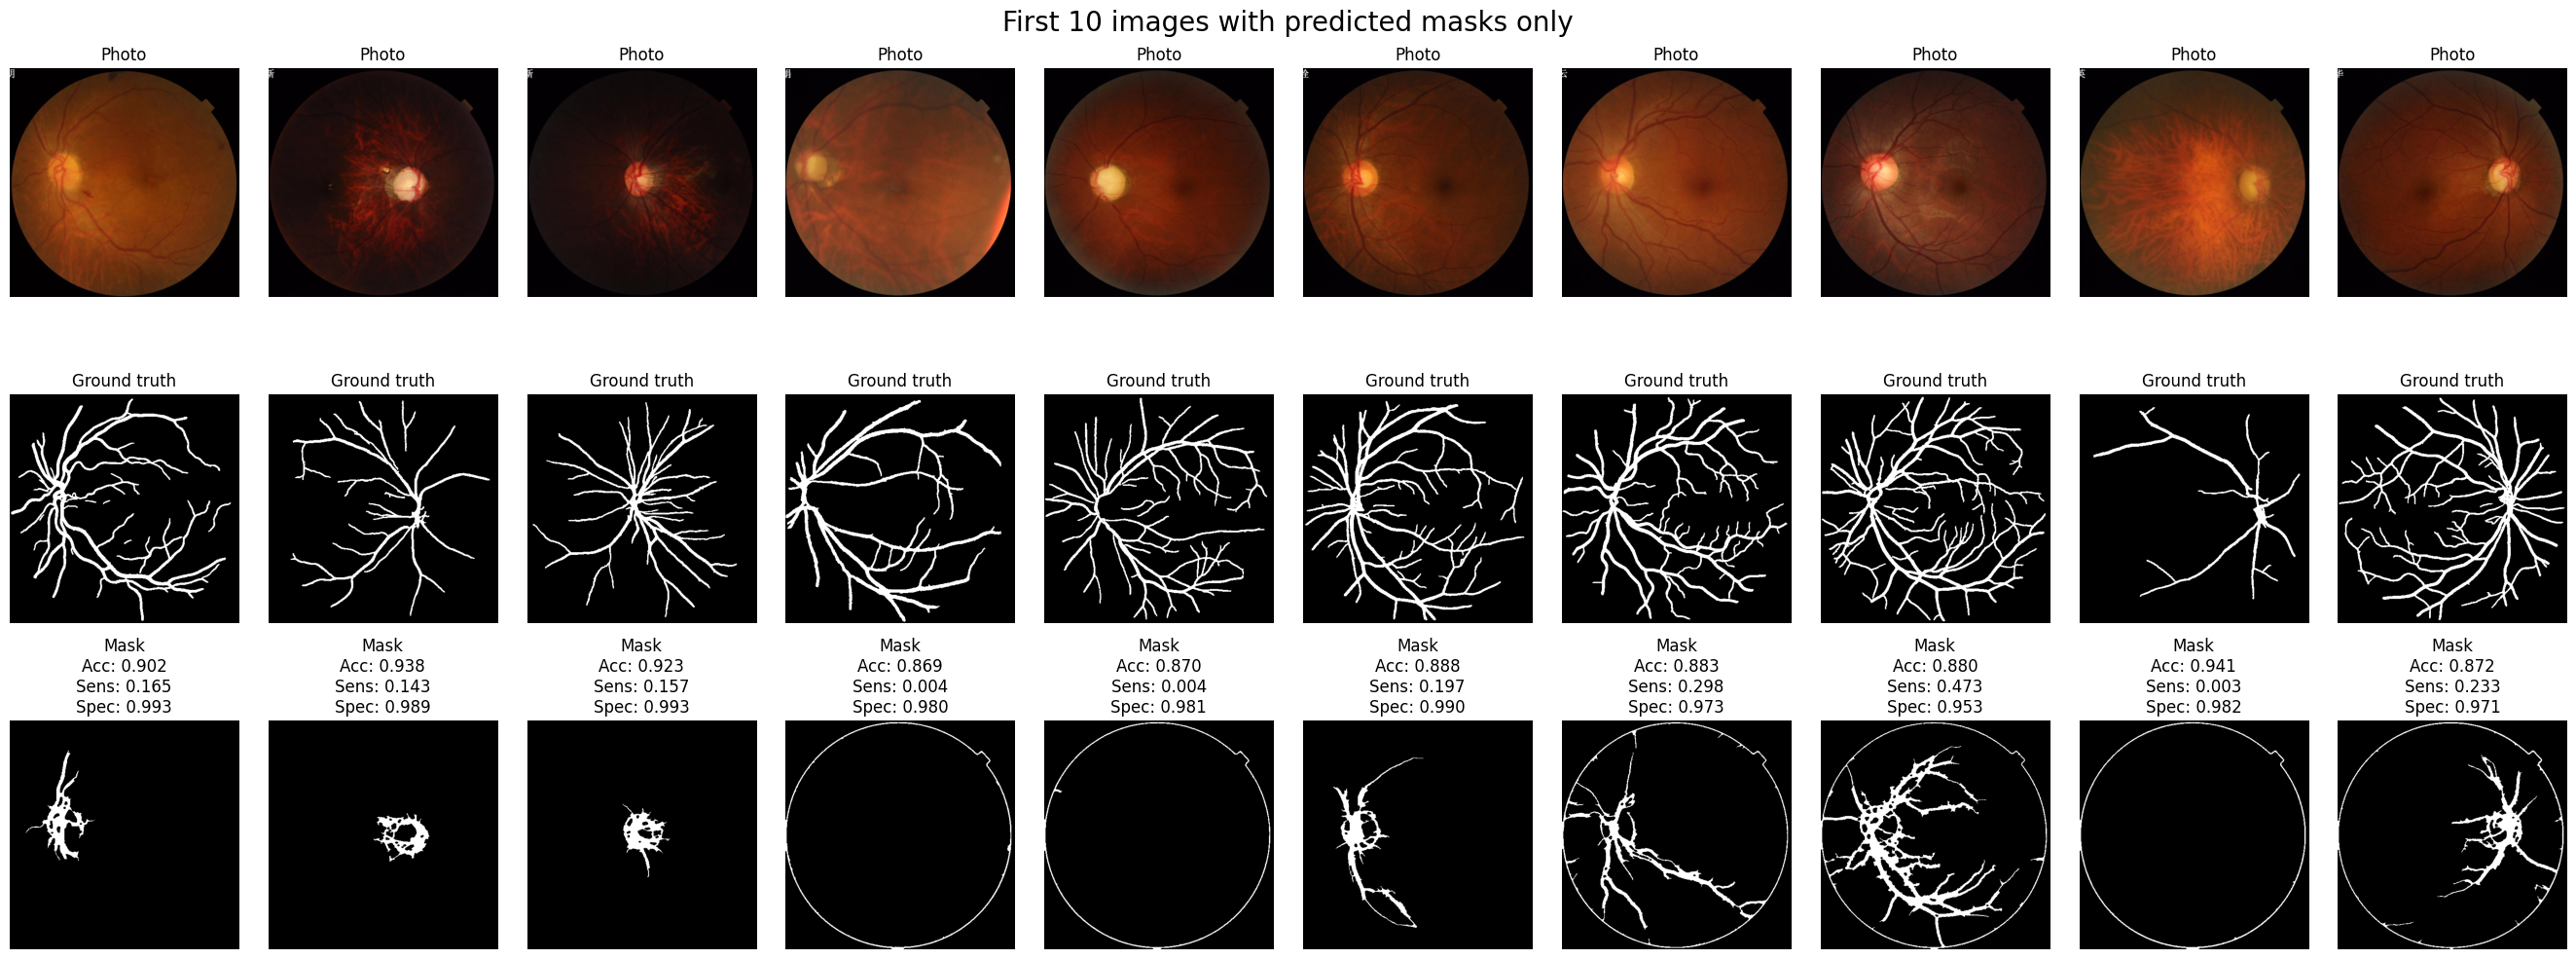

Global avg accuracy: 0.884
Global avg sensitivity: 0.252
Global avg specificity: 0.959


In [18]:
plot_results([test_raw_photos, test_masks, test_masks_postprocessed], 'First 10 images with predicted masks only', n=10)

# Updated code

In [ ]:
test_photo_paths = [input_path + 'test/image/' + x for x in os.listdir(input_path + 'test/image/')]
#test_label_paths = [input_path + 'test/mask/' + x for x in os.listdir(input_path + 'test/mask/')]

test_raw_photos = [cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB) for path in test_photo_paths]
#test_masks = [cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2GRAY) for path in test_label_paths]
#test_masks = np.array(test_masks).astype(np.uint8)
#test_masks = [np.where(mask > 0, 255, 0) for mask in test_masks]

test_photos_green = [photo[:, :, 1] for photo in test_raw_photos]
test_photos = [clahe.apply(photo) for photo in test_photos_green]
test_masks_sharr = [cv2.magnitude(cv2.Scharr(photo, cv2.CV_64F, 1, 0), cv2.Scharr(photo, cv2.CV_64F, 0, 1)) for photo in test_photos]
test_masks_postprocessed = basic_approach_postprocess(test_masks_sharr)

In [1]:
def accuracy_score(postprocessed_mask):
    unique_values = np.unique(postprocessed_mask)
    binarized_pixels = (unique_values == 0).sum() + (unique_values == 255).sum()
    return binarized_pixels / postprocessed_mask.size

def sensitivity_score(postprocessed_mask):
    edges = cv2.Canny(postprocessed_mask, 50, 150)
    return np.sum(edges > 0) / postprocessed_mask.size

def specificity_score(postprocessed_mask):
    background = np.sum(postprocessed_mask == 0)
    return background / postprocessed_mask.size

def get_quality(postprocessed_masks):
    accuracy_scores = [accuracy_score(mask) for mask in postprocessed_masks]
    sensitivity_scores = [sensitivity_score(mask) for mask in postprocessed_masks]
    specificity_scores = [specificity_score(mask) for mask in postprocessed_masks]
    return accuracy_scores, sensitivity_scores, specificity_scores

In [2]:
def plot_results(imagesSet, title, figsize=(18, 6), n=10):
    # Extract metrics for postprocessed masks
    accuracy_scores, sensitivity_scores, specificity_scores = get_quality(imagesSet[1])
    
    if n > len(imagesSet[0]):
        n = len(imagesSet[0])

    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=20)
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(imagesSet[0][i], cmap='gray')
        plt.axis('off')
        plt.title('Photo')

        plt.subplot(2, n, i + n + 1)
        plt.imshow(imagesSet[1][i], cmap='gray')
        plt.axis('off')
        plt.title('Mask\nAcc: {:.3f}\nSens: {:.3f}\nSpec: {:.3f}'.format(
            accuracy_scores[i], sensitivity_scores[i], specificity_scores[i]
        ))
    
    plt.tight_layout()
    plt.show()

    # Print global metrics
    print('Global avg accuracy: {:.3f}'.format(sum(accuracy_scores) / len(accuracy_scores)))
    print('Global avg sensitivity: {:.3f}'.format(sum(sensitivity_scores) / len(sensitivity_scores)))
    print('Global avg specificity: {:.3f}'.format(sum(specificity_scores) / len(specificity_scores)))

In [3]:
plot_results([test_raw_photos, test_masks_postprocessed], 'First 10 images with predicted masks only', n=10)

NameError: name 'test_raw_photos' is not defined

# Intermediate Vessel Extracting

In [20]:
def features_extracting(photo_batch):
    color_variance = np.var(photo_batch, axis=(1, 2))
    hu_moments = np.zeros((len(photo_batch), 7))
    for i, photo in enumerate(photo_batch):
        mu = moments_central(photo, order=5)
        nu = moments_normalized(mu)
        hu = moments_hu(nu)
        hu_moments[i] = hu

    features = np.concatenate((color_variance.reshape(-1, 1), hu_moments), axis=1)
    return features

def create_dataset(photos, masks, size=5, step=1):
    ds_photos = []
    ds_masks = []
    for photo, mask in zip(photos, masks):
        photo_pad = np.pad(photo, ((size // 2, size // 2), (size // 2, size // 2)), mode='constant')
        mask_pad = np.pad(mask, ((size // 2, size // 2), (size // 2, size // 2)), mode='constant')

        # Extract patches
        patches_photo = view_as_windows(photo_pad, (size, size), step=step).reshape(-1, size, size)
        patches_mask = view_as_windows(mask_pad, (size, size), step=step).reshape(-1, size, size)

        # Extract features for all patches in a batch
        batched_features = features_extracting(patches_photo)

        ds_photos.extend(batched_features)
        ds_masks.extend(patches_mask[:, size // 2, size // 2])  # Extract central pixel from each mask patch

    return ds_photos, ds_masks

def undersampling(photos, masks):
    photos_0 = []
    photos_225 = []
    for i in range(len(masks)):
        if masks[i] == 0:
            photos_0.append(photos[i])
        else:
            photos_225.append(photos[i])

    print(len(photos_0), len(photos_225))
    np.random.shuffle(photos_0)
    photos_0 = photos_0[:len(photos_225)]
    photos = photos_0 + photos_225
    masks = [0] * len(photos_0) + [225] * len(photos_225)
    return photos, masks

train_features, train_pred = create_dataset(train_photos, train_masks, size=5, step=5)

In [21]:
train_features_under, train_pred_under = undersampling(train_features, train_pred)

5606330 748461


In [22]:
print(train_pred_under.count(0), train_pred_under.count(225))

748461 748461


In [23]:
rf_classifier = KNeighborsClassifier(n_neighbors=5)
rf_classifier.fit(train_features_under, train_pred_under)

KNeighborsClassifier()

In [24]:
pickle.dump(rf_classifier, open(output_path + 'knnclassifier.pth', 'wb'))

In [25]:
y_pred_images = []
for photo, mask in zip(test_photos, test_masks):
    test_features, test_pred = create_dataset([photo], [mask], size=5)
    y_pred = rf_classifier.predict(test_features)
    y_pred_img = np.zeros((512, 512))
    for i in range(0, 512):
        for j in range(0, 512):
            y_pred_img[i][j] = y_pred[i * 512 + j]
    y_pred_images.append(y_pred_img)

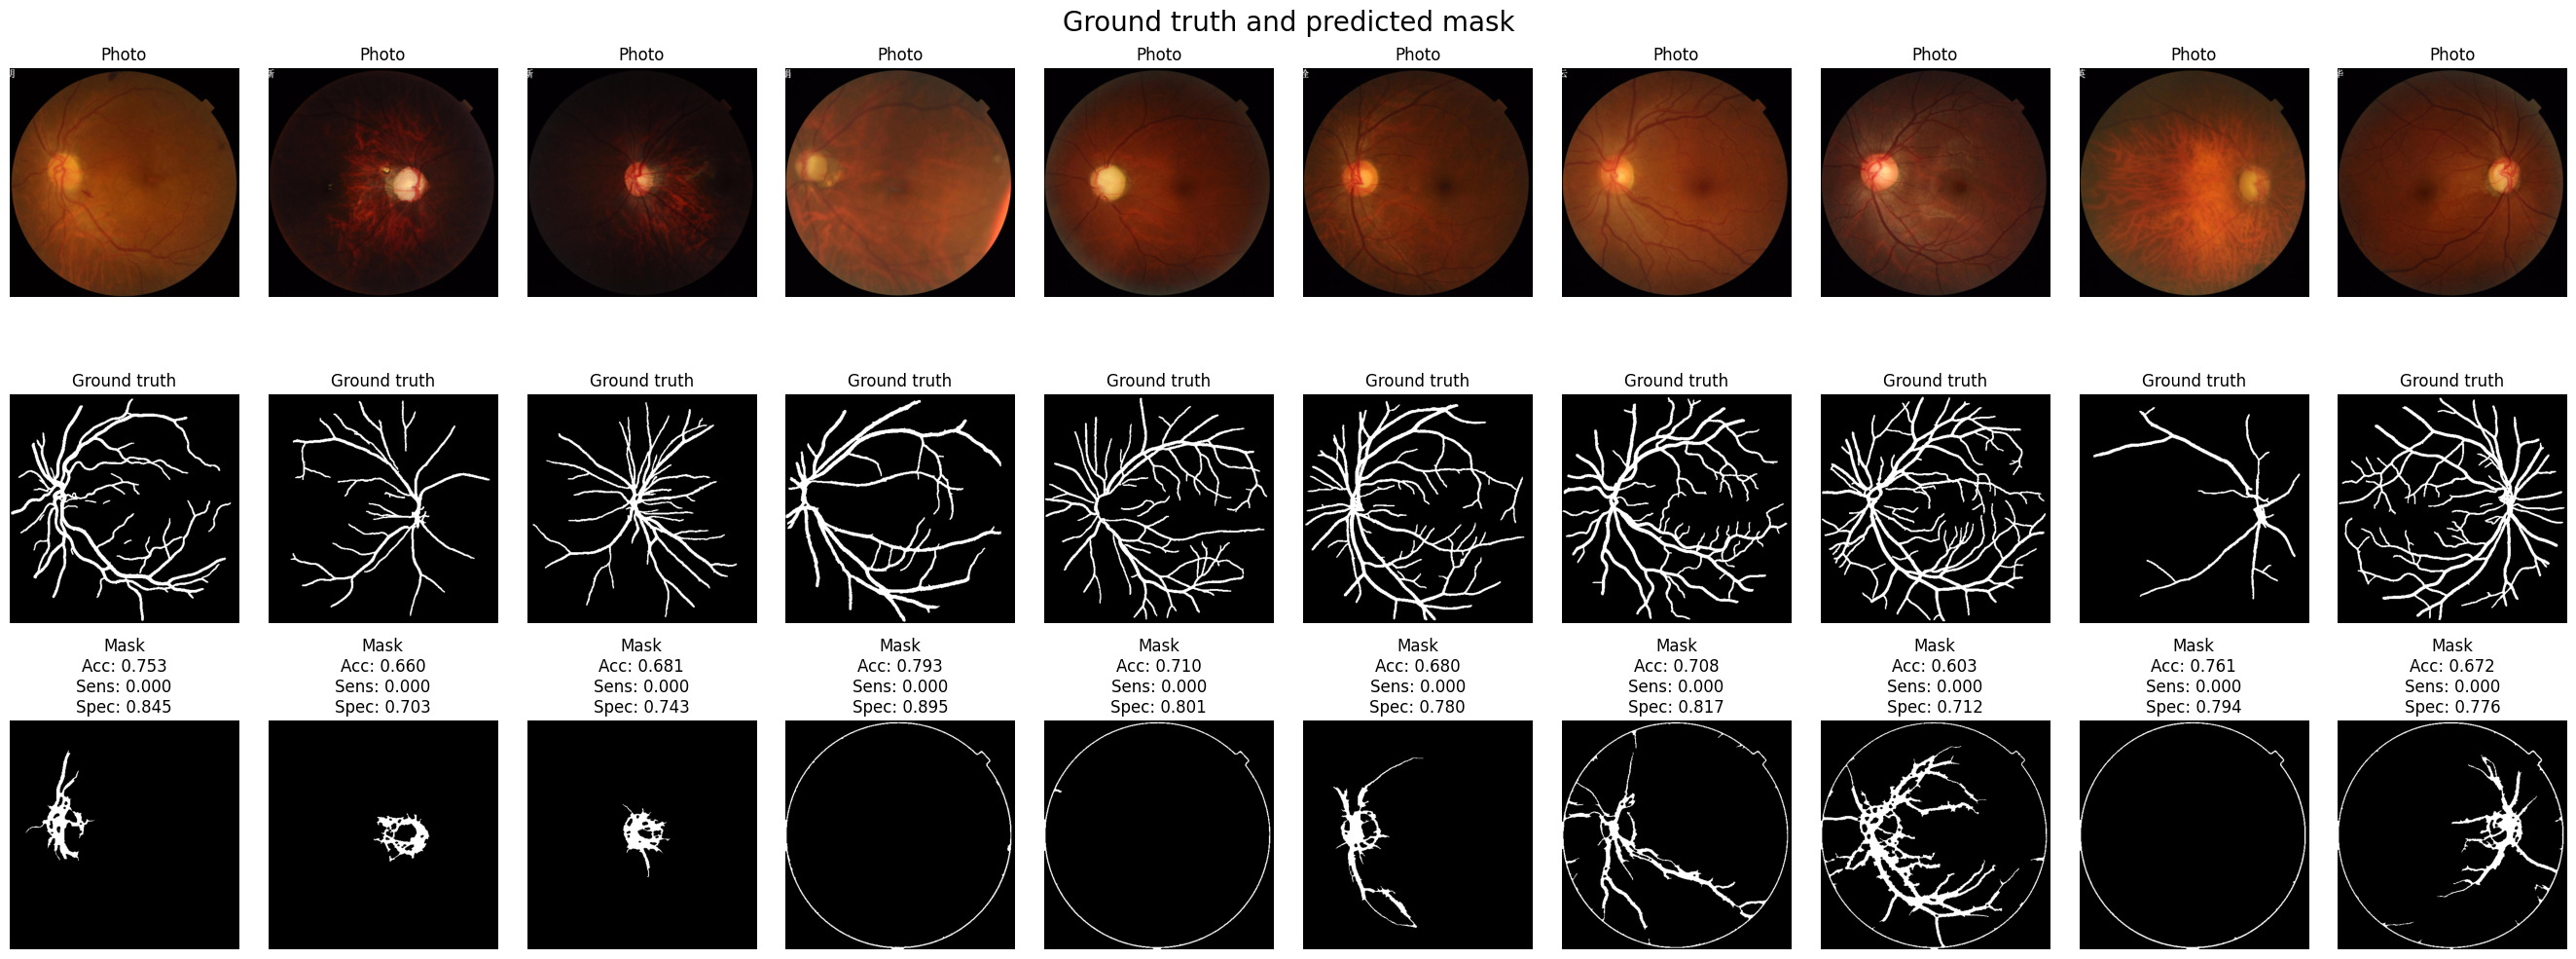

Global avg accuracy: 0.686
Global avg sensitivity: 0.000
Global avg specificity: 0.773


In [26]:
plot_results([test_photos, test_masks, y_pred_images], 'Ground truth and predicted mask')


# Advanced Vessel Extracting - Deep learning

In [19]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvolutionBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x

class UpConvolutionBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UpConvolutionBlock, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, H):
        super(AttentionBlock, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, H, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(H)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, H, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(H)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(H, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class AttentionU_Net(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super(AttentionU_Net, self).__init__()

        n_filter = 64

        self.MaxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.MaxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.MaxPool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.MaxPool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvolutionBlock(in_ch, n_filter)
        self.Conv2 = ConvolutionBlock(n_filter, 2*n_filter)
        self.Conv3 = ConvolutionBlock(2*n_filter, 4*n_filter)
        self.Conv4 = ConvolutionBlock(4*n_filter, 8*n_filter)
        self.Conv5 = ConvolutionBlock(8*n_filter, 16*n_filter)

        self.Up4 = UpConvolutionBlock(16*n_filter, 8*n_filter)
        self.Up3 = UpConvolutionBlock(8*n_filter, 4*n_filter)
        self.Up2 = UpConvolutionBlock(4*n_filter, 2*n_filter)
        self.Up1 = UpConvolutionBlock(2*n_filter, n_filter)

        self.Attention4 = AttentionBlock(F_g=8*n_filter, F_l=8*n_filter, H=4*n_filter)
        self.Attention3 = AttentionBlock(F_g=4*n_filter, F_l=4*n_filter, H=2*n_filter)
        self.Attention2 = AttentionBlock(F_g=2*n_filter, F_l=2*n_filter, H=n_filter)
        self.Attention1 = AttentionBlock(F_g=n_filter, F_l=n_filter, H=n_filter//2)

        self.UpConv4 = ConvolutionBlock(16*n_filter, 8*n_filter)
        self.UpConv3 = ConvolutionBlock(8*n_filter, 4*n_filter)
        self.UpConv2 = ConvolutionBlock(4*n_filter, 2*n_filter)
        self.UpConv1 = ConvolutionBlock(2*n_filter, n_filter)

        self.Conv = nn.Conv2d(n_filter, out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        cat = self.Conv1(x)

        cat2 = self.MaxPool1(cat)
        cat2 = self.Conv2(cat2)

        cat3 = self.MaxPool2(cat2)
        cat3 = self.Conv3(cat3)

        cat4 = self.MaxPool3(cat3)
        cat4 = self.Conv4(cat4)

        out = self.MaxPool4(cat4)
        out = self.Conv5(out)

        # -------------------------------

        out = self.Up4(out)
        att = self.Attention4(g=out, x=cat4)
        out = torch.cat((att, out), dim=1)
        out = self.UpConv4(out)

        out = self.Up3(out)
        att = self.Attention3(g=out, x=cat3)
        out = torch.cat((att, out), dim=1)
        out = self.UpConv3(out)

        out = self.Up2(out)
        att = self.Attention2(g=out, x=cat2)
        out = torch.cat((att, out), dim=1)
        out = self.UpConv2(out)

        out = self.Up1(out)
        att = self.Attention1(g=out, x=cat)
        out = torch.cat((att, out), dim=1)
        out = self.UpConv1(out)

        out = self.Conv(out)

        return out

class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss,self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [20]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, photos, masks, transform=None):
        self.photos = photos
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.photos)

    def __getitem__(self, idx):
        photo = self.photos[idx]
        mask = self.masks[idx]

        if self.transform:
            photo, mask = self.transform(photo, mask)

        return photo, mask

In [21]:
def train_step(model, optimizer, loss_fn,loader, device):
    epoch_loss =0.0
    model.train()

    for x,y in tqdm(loader):
        x = x.to(device,dtype = torch.float32)
        y = y.to(device, dtype = torch.float32)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        epoch_loss +=loss.item()

    return epoch_loss/len(loader)

def valid_step(model, loader, loss_fn,device):
    epoch_loss = 0.0
    model.eval()

    with torch.inference_mode():
        for x, y in loader:
            x = x.to(device,dtype = torch.float32)
            y = y.to(device, dtype = torch.float32)
            pred = model(x)
            loss = loss_fn(pred,y)
            epoch_loss +=loss.item()
    return epoch_loss/len(loader)

def Train(model, optimizer, loss_fn, train_loader, valid_loader, device, saved_model_path, num_epochs = 10, patience = 3):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    patience_counter = 0
    for epoch in range(num_epochs):
        train_loss = train_step(model,optimizer,loss_fn,train_loader,device)
        val_loss = valid_step(model,valid_loader,loss_fn,device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), saved_model_path)
            patience_counter = 0
        else:
            patience_counter +=1
            if patience_counter >= patience:
                print("Training stopped early.")
                return train_losses, val_losses

        gc.collect()
        torch.cuda.empty_cache()
    return train_losses, val_losses

def visualizeTraining(train_losses, val_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training Loss and Validation Loss')
    plt.legend()
    plt.show(block=False)

In [22]:
num_epochs = 20
lr=1e-3
batch_size = 1
patience = 3

In [23]:
train_image_transform = v2.Compose([
    v2.ToPILImage(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=90),
    v2.RandomCrop(size=(224, 224)),
    v2.Grayscale(num_output_channels=1),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485], std=[0.229]),
])

c:\Users\fix_e\anaconda3\envs\zoha31015\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# Skip the below cell

In [ ]:
#split train to train and valid with 90/10
split_position = int(len(train_photos) * 0.9)
train_photos, valid_photos = train_photos[:split_position], train_photos[split_position:]
valid_photos, valid_masks = train_masks[:split_position], train_masks[split_position:]

#create dataset
train_dataset = Dataset(train_photos, valid_photos, transform=train_image_transform)
valid_dataset = Dataset(valid_photos, valid_masks, transform=train_image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# UPDATE (Below cell)

In [24]:
#split train to train and valid with 90/10
split_position = int(len(train_photos) * 0.9)
train_photos, valid_photos = train_photos[:split_position], train_photos[split_position:]
train_masks, valid_masks = train_masks[:split_position], train_masks[split_position:]

#create dataset
train_dataset = Dataset(train_photos, train_masks, transform=train_image_transform)
valid_dataset = Dataset(valid_photos, valid_masks, transform=train_image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = DiceBCELoss()

saved_model_path = 'model.pth'

model = AttentionU_Net(1,1)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [26]:
train_losses, val_losses = Train(model, optimizer, loss_fn, train_loader, valid_loader, device, num_epochs=num_epochs, patience=patience, saved_model_path=(output_path + saved_model_path))

  0%|          | 0/539 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.5806
Validation Loss: 2.1918


  0%|          | 0/539 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.3983
Validation Loss: 0.4473


  0%|          | 0/539 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.3519
Validation Loss: 0.4072


  0%|          | 0/539 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.3352
Validation Loss: 0.3560


  0%|          | 0/539 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.3141
Validation Loss: 0.3367


  0%|          | 0/539 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.3050
Validation Loss: 0.2784


  0%|          | 0/539 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.2922
Validation Loss: 0.2713


  0%|          | 0/539 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.2999
Validation Loss: 0.2668


  0%|          | 0/539 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 0.2872
Validation Loss: 0.2951


  0%|          | 0/539 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 0.2899
Validation Loss: 0.2908


  0%|          | 0/539 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.2821
Validation Loss: 0.2776
Training stopped early.


### The training is stopped early when the validation loss does not improve for a specified number of consecutive epochs.

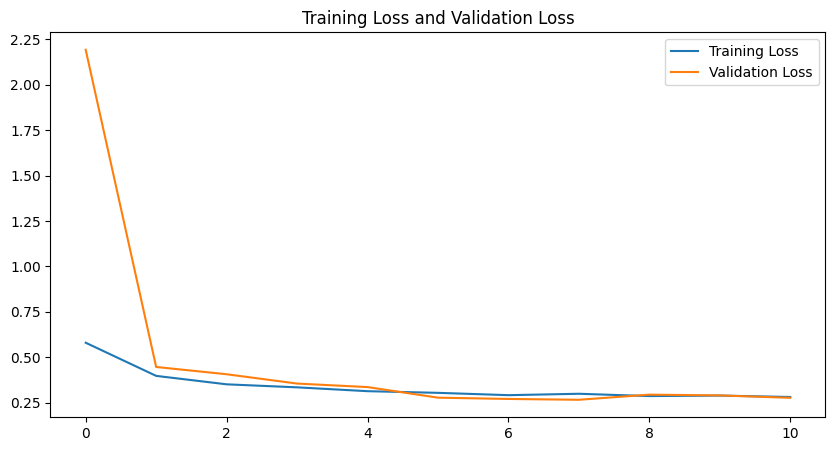

In [27]:
visualizeTraining(train_losses, val_losses)

In [29]:
test_image_transform = v2.Compose([
    v2.ToPILImage(),
    v2.Grayscale(num_output_channels=1),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485], std=[0.229]),
])

In [30]:
x = test_image_transform(test_photos[0])
x = x[:, None, :, :]
x.to(device, dtype=torch.float32)
pred = model(x)

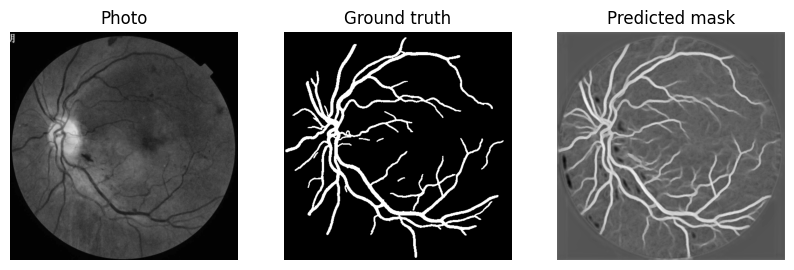

In [31]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_photos[0], cmap='gray')
plt.axis('off')
plt.title('Photo')
plt.subplot(1, 3, 2)
plt.imshow(test_masks[0], cmap='gray')
plt.axis('off')
plt.title('Ground truth')
plt.subplot(1, 3, 3)
plt.imshow(pred[0, 0].detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted mask')
plt.show()